In [1]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import os

**Directories** 

Load data 'nd stuff

In [2]:
data_dir = '../data/'
peptides_file = data_dir + "PSSM/A0201.eval"
peptides = np.loadtxt(peptides_file, dtype=str).tolist()

**One-hot encoding**

In [3]:
aa = "ACDEFGHIKLMNPQRSTVWY"
aa_to_int = dict((c, i) for i, c in enumerate(aa))

def encode_peptide(peptide):
    encoding = np.zeros((len(peptide), len(aa)))
    for i, AA in enumerate(peptide):
        encoding[i, aa_to_int[AA]] = 1
    return encoding

**Data preparation**

In [4]:
targets = []
encodings = []
for peptide, score in peptides:
    X = np.array([encode_peptide(amino_acid) for amino_acid in peptide])
    score = float(score)
    encodings.append(X)
    targets.append(float(score))

tensor_input = torch.stack([torch.tensor(arr) for arr in encodings])
tensor_input = tensor_input.squeeze(dim=2).float()  
targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(1)  

# Split into training and evaluation sets (80/20 split)
eval_size = int(0.2 * len(encodings))
train_encodings, eval_encodings = tensor_input[:-eval_size], tensor_input[-eval_size:]
train_targets, eval_targets = targets[:-eval_size], targets[-eval_size:]

**Network**

In [10]:
class OHEBase(nn.Module):
    def __init__(self, input_size, hidden_size, num_vectors):
        super(OHEBase, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=20, out_channels=hidden_size, kernel_size=1)
        self.fc1 = nn.Linear(hidden_size * num_vectors, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = x.transpose(1, 2)  # Change shape to (batch_size, 20, 9) for Conv1d
        x = torch.relu(self.conv1(x))  # Apply Conv1d
        x = x.view(x.size(0), -1)  # Flatten the output (batch_size, hidden_size * 9)
        x = torch.relu(self.fc1(x))  # Pass through a fully connected layer
        x = self.output(x)  # Final output layer
        return x

# Set input and hidden sizes
input_size = 20  # Each vector has 20 features
hidden_size = 16  # Number of output channels in Conv1d
num_vectors = 9  # Number of vectors (sequence length)

# Define the loss function
loss_function = nn.MSELoss()  # Mean Squared Error Loss for regression tasks

torch.manual_seed(69)

**Execution**

Outer Fold 1/5
  Inner Fold 1/5
  Inner Fold 2/5
  Inner Fold 3/5
  Inner Fold 4/5
  Inner Fold 5/5
  Average Inner Validation Loss: 0.0266
Outer Fold Validation Loss: 0.0275
Outer Fold 2/5
  Inner Fold 1/5
  Inner Fold 2/5
  Inner Fold 3/5
  Inner Fold 4/5
  Inner Fold 5/5
  Average Inner Validation Loss: 0.0287
Outer Fold Validation Loss: 0.0180
Outer Fold 3/5
  Inner Fold 1/5
  Inner Fold 2/5
  Inner Fold 3/5
  Inner Fold 4/5
  Inner Fold 5/5
  Average Inner Validation Loss: 0.0233
Outer Fold Validation Loss: 0.0209
Outer Fold 4/5
  Inner Fold 1/5
  Inner Fold 2/5
  Inner Fold 3/5
  Inner Fold 4/5
  Inner Fold 5/5
  Average Inner Validation Loss: 0.0218
Outer Fold Validation Loss: 0.0312
Outer Fold 5/5
  Inner Fold 1/5
  Inner Fold 2/5
  Inner Fold 3/5
  Inner Fold 4/5
  Inner Fold 5/5
  Average Inner Validation Loss: 0.0301
Outer Fold Validation Loss: 0.0194
Evaluation Set Loss: 0.0183
Pearson Correlation Coefficient (PCC) on Evaluation Set: 0.7945


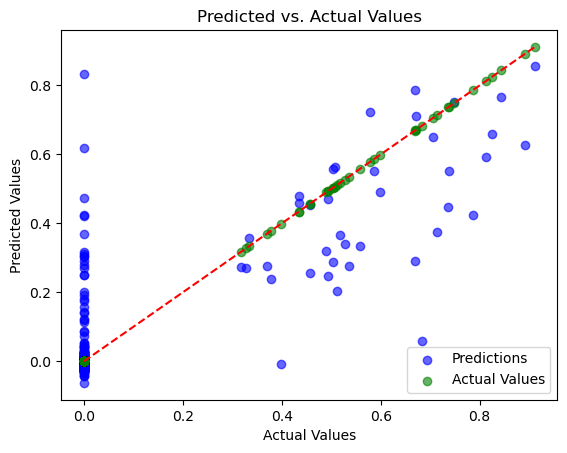

Nested cross-validation complete.


In [14]:
outer_kf = KFold(n_splits=5, shuffle=True)
inner_kf = KFold(n_splits=5, shuffle=True)

outer_fold_results = []

for outer_fold, (train_index, val_index) in enumerate(outer_kf.split(train_encodings)):
    print(f"Outer Fold {outer_fold+1}/5")
    
    # Split data into training and validation sets
    X_train, X_val = train_encodings[train_index], train_encodings[val_index]
    y_train, y_val = train_targets[train_index], train_targets[val_index]
    
    inner_fold_results = []
    
    for inner_fold, (inner_train_idx, inner_val_idx) in enumerate(inner_kf.split(X_train)):
        print(f"  Inner Fold {inner_fold+1}/5")
        
        X_inner_train, X_inner_val = X_train[inner_train_idx], X_train[inner_val_idx]
        y_inner_train, y_inner_val = y_train[inner_train_idx], y_train[inner_val_idx]
        
        model = OHEBase(input_size, hidden_size, num_vectors)
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        for epoch in range(100):
            optimizer.zero_grad()
            outputs = model(X_inner_train)
            loss = loss_function(outputs, y_inner_train)
            loss.backward()
            optimizer.step()
        
        with torch.no_grad():
            val_outputs = model(X_inner_val)
            val_loss = loss_function(val_outputs, y_inner_val).item()
            inner_fold_results.append(val_loss)
    
    avg_inner_val_loss = np.mean(inner_fold_results)
    print(f"  Average Inner Validation Loss: {avg_inner_val_loss:.4f}")
    
    model = OHEBase(input_size, hidden_size, num_vectors)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    for epoch in range(100):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = loss_function(outputs, y_train)
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = loss_function(val_outputs, y_val).item()
        outer_fold_results.append(val_loss)
    print(f"Outer Fold Validation Loss: {val_loss:.4f}")

# Evaluate the final model on the evaluation set and plot predictions
model = OHEBase(input_size, hidden_size, num_vectors)
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(train_encodings)
    loss = loss_function(outputs, train_targets)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    eval_outputs = model(eval_encodings)
    eval_loss = loss_function(eval_outputs, eval_targets).item()
    print(f"Evaluation Set Loss: {eval_loss:.4f}")

    # Calculate Pearson Correlation Coefficient (PCC)
    eval_outputs = eval_outputs.squeeze().numpy()
    eval_targets_np = eval_targets.squeeze().numpy()
    pcc, _ = pearsonr(eval_outputs, eval_targets_np)
    print(f"Pearson Correlation Coefficient (PCC) on Evaluation Set: {pcc:.4f}")

    # Create a scatter plot
    plt.scatter(eval_targets_np, eval_outputs, color='blue', alpha=0.6, label='Predictions')
    plt.scatter(eval_targets_np, eval_targets_np, color='green', alpha=0.6, label='Actual Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs. Actual Values')
    plt.plot([min(eval_targets_np), max(eval_targets_np)], [min(eval_targets_np), max(eval_targets_np)], 'r--')  # Diagonal line
    plt.legend()

    # Save the plot in the same location as the script
#    script_dir = os.path.dirname(os.path.abspath(__file__))  # Get the directory of the script
#    plot_path = os.path.join(script_dir, 'predicted_vs_actual_plot.png')
#    plt.savefig(plot_path)
    plt.show()

print("Nested cross-validation complete.")